In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math
from math import inf
from datetime import datetime,timedelta
import random
from datetime import datetime, timedelta

OGGM Climate Source: GSWP3_W5E5

1984 extent: 3251 meters
This was calculated by measuring the length of the glacier along the centerline on a polygon of the glacier from 1958. Then extent change date from FoG_FVobs_205.csv was used to calculate the change in extent from 1958-1984

In [12]:
#Initialize the input files variables
input_files={}
input_files['bed']='Data/centerlineBed.csv' #FORMAT: csv with columns, elevation, longitude, latitude
input_files['area']='Data/Input_SouthCascade_Area_Altitude_Distribution.csv' #FORMAT: csv with first row mean elevation of bin, then columns of year, area per bin
input_files['temp_precip']='Data/Input_SouthCascade_Daily_Weather.csv' #FORMAT: csv with columns date, temperature, precipitation
input_files['mass_balance']='Data/Output_SouthCascade_Glacier_Wide_solutions_calibrated.csv' #FORMAT: csv with columns year, winter mass balance, summer mass balance, annual mass balance, ela
input_files['runoff']='Data/runoff_m3_1992-2007.csv' #FORMAT: csv with columns date, runoff
input_files['thickness_change']='Data/thickness_change.csv' #FORMAT: csv with columns date, thickness change
input_files['front_variation']='Data/front_variation_change.csv' #FORMAT: csv with columns date, front variation change
#Fix basin_area file to represent the new polygon in arcgis
input_files['basin_area']='Data/basin_wide_area_elev_bands.csv' #FORMAT: csv with columns area, mean elevation of bin
input_files['glacier_1958']='Data/centerlineThickness_1958.csv' #FORMAT: csv with columns bed elevation, longitude, latitude, elevation in 1986
input_files['glacier_1986']='Data/centerlineThickness_1986.csv' #FORMAT: csv with columns bed elevation, longitude, latitude, elevation in 1986
input_files['glacier_2021']='Data/centerlineThickness_2021.csv' #FORMAT: csv with columns bed elevation, longitude, latitude, elevation in 2021

In [13]:
class glacierSim():
    def __init__(self, ela=1880,ela_1900=1650,time=500,save=10,gamma=0.01,quiet=True, tune_factors=[-0.004,-0.002,0.0065,1.6,2.2,5,0.006], initial_ice=None, start_time=0, input_files=None):
        #MODEL VARS:
        self.valley_length=0 #in m, defined in calc_topo
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.ela_1900=ela_1900
        self.num_cells = 50 #set number of cells
        self.dx = 0 #cell width in m, will be calculated in calc_topo
        if start_time==0: self.ice = np.zeros(self.num_cells) #initialize ice
        else: self.ice = np.array(initial_ice)
        
        #PLOTTING VARS:
        self.ice_line_list=[] #stores info for plotting ice
        self.snow_line_list=[] #stores info for plotting snow
        self.ela_line_list=[] #stores info for plotting ela
        self.title_list=[] #stores info for plotting title
        self.x = np.zeros(self.num_cells) #used for plotting topography and ice thickness, defined in calc_topo
        self.topo =[] #initialize topography
        self.quiet=quiet #set to true to printout values while model is running
        
        #ICE FLUX VARS:
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.ice_slope = np.zeros(self.num_cells) #initialize ice_slope
        
        #TIME VARS:
        self.time=start_time*365.25 #DAYS
        self.prev_display=0 #used for displaying model data while running when quiet=false
        self.time = time #simulation time in years
        # self.current_date=datetime(1484,1,1)+timedelta(days=start_time*365.25)
        if start_time==0: self.current_date=datetime(1484,1,1)
        else: self.current_date=datetime(1984,1,1)
        self.save = save*365.25 #timestep interval in days
        self.frames = ((int)((self.time-start_time)/(self.save/365.25)))+1 #number of frames the animation will run for
        self.timestep_list=[] #days
        
        #MASS BALANCE VARS:
        self.b_max = float(-inf) #maximum yearly mass balance value for whole run
        self.b_min = float(inf) #minimum yearly mass balance valeu for whole run
        self.gamma = gamma #for mass balance equation
        self.b=np.zeros(self.num_cells) #initialize mass balance
        self.weather_dates=[] #dates for weather data
        self.temps=[] #daily temperatures
        self.precip=[] #daily precipitation
        
        #SNOW VARS:
        self.snow_depth=np.zeros(self.num_cells) #snow depth along glacier in m
        self.snow_melt_amt=np.zeros(self.num_cells) #snow melt amount in m
        self.snow_depth_list=[]
        self.avalanche_dates=[self.current_date]*4
        
        #TUNE FACTORS:
        self.ice_melt_factor=tune_factors[0] #factor to change how much the ice melts per degree C
        self.snow_melt_factor=tune_factors[1] #factor to change how much the snow melts per degree C
        self.temp_lapse_rate=tune_factors[2] #temp lapse rate in C/m]
        self.accumfactor_lower=tune_factors[3] #lower bound to change how much snow gets turned into ice
        self.accumfactor_upper=tune_factors[4] #upper bound to change how much snow gets turned into ice
        self.avalanche_percent=tune_factors[5] #factor to change how much precip gets turned to snow
        self.precip_conv_factor=tune_factors[6] #precipitation lapse rate in m/m
        
        #VERIF VARS:
        #MB VARS
        self.annual_mb=[] #annual mass balance verif data
        self.winter_mb=[] #winter (positive) mass balance verif data
        self.summer_mb=[] #summer (negative) mass balance verif data
        #GLAICER VARS
        self.thickness_change_verif=np.zeros(4) #thickness change for verif
        self.front_variation_verif=np.zeros(100) #front variation verification data
        self.ela_verif=np.zeros(100) #ela's for verification
        self.thickness_1958_verif=0 #thickness in 1958 for verif
        self.thickness_1986_verif=0 #thickness in 1986 for verif
        self.thickness_2021_verif=0 #thickness in 2021 for verif
        #RUNOFF VARS
        self.measured_runoff_training=[] #holds daily runoff data for training
        self.measured_runoff_verif=[] #holds daily runoff data for verification
        self.measured_runoff_all=[]
        self.date_index_training=[] #holds date index for training data
        self.date_index_verif=[] #holds date index for verification data
        self.date_index_all=[] #holds date index for all data
        
        #CALCULATED VERIF VARS:
        #MB VARS
        self.calculated_annual_mb=np.zeros(40, dtype=np.float64) #used to verify annual mass balance
        self.calculated_winter_mb=np.zeros(40, dtype=np.float64) #used to verify winter (positive) mass balance
        self.calculated_summer_mb=np.zeros(40, dtype=np.float64) #used to verify summer (negative) mass balance
        self.year_mb=np.zeros(len(self.b)) #keeps track of the mb for the current year to calculate ela line
        #GLACIER VARS
        self.front_variation_calc=np.zeros(100) #model calculated front variation
        self.thickness_change=np.zeros(4) #model thickness change
        self.ice_1958=np.zeros(self.num_cells) #stores the ice in 1958
        self.ice_1986=np.zeros(self.num_cells) #stores the ice in 1986
        self.ice_2021=np.zeros(self.num_cells) #stores the ice in 2021
        self.glacier_extent=0 #length of glacier in m
        self.ice_thickness_over_time=[] #tracks avg ice thickness over time
        self.ela_list=[] #list of ela values over time, used for verif
        #RUNOFF VARS
        self.glacial_melt=0
        self.rain_vol_per_step=0
        self.snow_melt_vol=0 #volume of melted snow in m^3, used to factor in snowmelt to volume calculations for stream flow data comparisons
        self.daily_runoff_training=[] #holds daily runoff data for training
        self.daily_runoff_verif=[] #holds daily runoff data for verification
        self.daily_runoff_all_data=[]
        self.monthly_runoff_all=np.zeros((self.time-start_time)*12+1) #holds daily runoff data for all data
        self.monthly_glacier_melt=np.zeros((self.time-start_time)*12+1) #holds daily runoff data for all data
        self.precip_accum=np.zeros(41)
        
        #PREV VARS:
        self.prev_thickness=np.mean(self.ice) #previous avg ice thickness used to calculate thickness change
        self.prev_front=np.max(self.x[self.ice>1]) if np.any(self.ice>1) else 0 #previous front location to calculate front var change
        
        #WIDTH VARS: 
        self.bins=[] #elevation bins for widths
        self.years=[] #years for width data
        self.areas=[] #area of glacier in m^2, used to calculate width
        self.year_area=np.zeros(self.num_cells)
        self.glacier_area=0
        
        #INPUT FILE VARS:
        if input_files is not None: self.input_files=input_files #list of input files for glacier data
        else: print("No input files provided")
        
    def init(self, ela=1880,ela_1900=1650,valley_length=3668, time=500,save=10,gamma=0.008, quiet=True, tune_factors=[-0.004,-0.002,0.0065,1.6,2.2,5,0.006], initial_ice=None, start_time=0, input_files=None): 
        self.__init__(ela, ela_1900, time, save, gamma, quiet, tune_factors, initial_ice, start_time, input_files)
        self.load_verif_data()
        self.calc_topo()
        self.load_area_data()
        self.load_weather_data()
        self.ela_list.append(self.topo[-1]) 

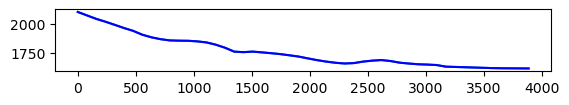

In [14]:

class glacierSim(glacierSim):
    #Used to calculate distance between two lat lon points to interpolate bed topo
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        latitudes = []
        longitudes = []
        topo = []
        #Load in the bed topo data
        df = pd.read_csv(self.input_files['bed'])
        latitudes = df.iloc[:, 2].astype(float).tolist()  # Latitude is the second column (index 2)
        longitudes = df.iloc[:, 1].astype(float).tolist()  # Longitude is the third column (index 1)
        topo = df.iloc[:, 0].astype(float).tolist()  # Elevation is the first column (index 0)
        cumulative_distances=[0.0]
        #Interpolate the bed topo data into my topo array with a set number of cells
        for i in range(1, len(latitudes)): cumulative_distances.append(cumulative_distances[-1] + self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) )
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells) #creates self.x values
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, topo) #interpolates bed topo to get elevations at self.x values
        #Reinitialize the valley length, dx and ice slope
        self.valley_length=np.max(self.x)
        self.dx = self.valley_length/(self.num_cells-1) #re-initializes dx using updates valley length
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx)) #initial ice slope is just topo slope
        #THIS CREATES A FAKE INITIAL ICE FOR ICE FLUX TESTING
        #self.ice=np.exp(-0.5 * ((self.x - 700) / 300) ** 2)
        #scale=300/np.max(self.ice)
        #self.ice*=scale
        #Load in the 2021 and 1986 glacier extent data for verification
        #This is done here instead of in the load_verif function below because 
        #it needs the cumulative_distances to interpolate the data onto the model arrays
        data_1958 = np.loadtxt(self.input_files['glacier_1958'], delimiter=',', skiprows=1)
        self.thickness_1958_verif = data_1958[:, 3] - data_1958[:, 0]
        data_1986 = np.loadtxt(self.input_files['glacier_1986'], delimiter=',', skiprows=1)
        self.thickness_1986_verif = data_1986[:, 3] - data_1986[:, 0]
        data_2021 = np.loadtxt(self.input_files['glacier_2021'], delimiter=',', skiprows=1)
        self.thickness_2021_verif = data_2021[:, 3] - data_2021[:, 0]
        self.thickness_1958_verif=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_1958_verif) if type(self.thickness_1958_verif) is not int else np.zeros(self.num_cells)
        self.thickness_1986_verif=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_1986_verif) if type(self.thickness_1986_verif) is not int else np.zeros(self.num_cells)
        self.thickness_2021_verif=np.maximum(np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.thickness_2021_verif) if type(self.thickness_2021_verif) is not int else np.zeros(self.num_cells),0)
        
    #Calculate the initial glacier area
    def load_area_data(self):
        #Load in the area data
        df = pd.read_csv(self.input_files['area'])
        self.bins = df.columns[2:].astype(float).to_numpy()
        self.years = df.iloc[:, 0].astype(float).tolist()
        self.areas = df.iloc[:, 2:].astype(float).to_numpy()*1000000 #convert to m^2
        self.bin_bounds=np.concatenate(([self.bins[0] - 25], (self.bins[:-1] + self.bins[1:]) / 2, [self.bins[-1] + 25]))
        #Call update_areas() to initialize the area arrays
        if self.current_date.year>=1984:self.update_areas()
                
    def update_areas(self):
        #Get the area for the current year, area data starts in 1950
        area=self.areas[(self.current_date.year-1950),:]
        bin_indices = np.digitize((self.topo+self.ice), self.bins)
        for i in range(len(area)):
            mask = (bin_indices == i)
            cell_indices = np.where(mask)[0]
            n_cells = len(cell_indices)
            if n_cells > 0:
                base_area = area[i] / n_cells
                self.year_area[mask] = base_area
                self.year_area[cell_indices[0]] += (area[i] - (base_area * n_cells))
        if np.sum(self.year_area)<np.sum(area): self.year_area+=(np.sum(area)-np.sum(self.year_area))/len(self.year_area)
        if round(np.sum(self.year_area))!=round(np.sum(area)):
            print("Warning: Year area does not equal area")
            print("Year area: ", round(np.sum(self.year_area)))
            print("Area: ", round(np.sum(area)))
            print("Difference: ", round(np.sum(self.year_area)-np.sum(area)))
        
glac=glacierSim(input_files=input_files)
glac.current_date=datetime(1984,1,1)
glac.calc_topo()
glac.load_area_data()
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo, color='b')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

8/15/1997 to 7/15/2001 inclusive is used as runoff training data and the rest is used for verification

In [15]:

class glacierSim(glacierSim):
    def load_weather_data(self):
        #Load temperature and precipitation data
        df = pd.read_csv(self.input_files['temp_precip'])
        self.dates = pd.to_datetime(df.iloc[:, 0], format="%Y/%m/%d").tolist()
        self.temps = df.iloc[:, 1].astype(float).to_numpy()
        self.precip = df.iloc[:, 2].apply(lambda x: float(x) if not np.isnan(float(x)) else 0).to_numpy()
        #MAKE NOTE OF THIS IN THESIS, SOME OF THE TEMPERATURE DATA IS INTERPOLATED BECAUSE ITS MISSING
        #If the temperature data is nan(missing data) then interpolate it
        nan_indices = np.isnan(self.temps)
        x = np.arange(len(self.temps))
        self.temps[nan_indices] = np.interp(x[nan_indices], x[~nan_indices], self.temps[~nan_indices])

    def load_verif_data(self):
        #Load the mass balance and ELA data
        #Skips the first 25 rows because they are before 1984
        df = pd.read_csv(self.input_files['mass_balance'], skiprows=25)
        self.annual_mb = df.iloc[:-1, 3].astype(float).tolist()
        self.summer_mb = df.iloc[:-1, 2].astype(float).tolist()
        self.winter_mb = df.iloc[:-1, 1].astype(float).tolist()
        self.ela_verif=df.iloc[5:, 4].astype(float).to_numpy()
        #Initialize the calculated mass balance arrays
        self.calculated_annual_mb=np.zeros(len(self.annual_mb))
        self.calculated_winter_mb=np.zeros(len(self.winter_mb))
        self.calculated_summer_mb=np.zeros(len(self.summer_mb))
        #Load the runoff data. 
        #I only have data from 1992-2007 and there are many gaps in that record so I keep track of what days I have data for 
        #and I keep track of that so I can only add the runoff data for those days to my calculated runoff arrays
        #Also the runoff data is summed by month so that there is less variability in the data
        df = pd.read_csv(self.input_files['runoff'])
        df['date'] = pd.to_datetime(df['date'])
        #Runoff training data variables
        training_start_date = "1997-08-15"
        training_end_date = "2001-07-15"
        training_data = df[(df["date"] >= training_start_date) & (df["date"] <= training_end_date)]
        self.measured_runoff_training = training_data.groupby(training_data["date"].dt.to_period("M"))["runoff"].sum().to_numpy()
        self.date_index_training = {date: idx for idx, date in enumerate(training_data['date'])}
        self.daily_runoff_training = np.zeros(len(self.date_index_training))
        #Runoff verification data variables
        verif_data = df[(df["date"] < training_start_date) | (df["date"] > training_end_date)]
        self.measured_runoff_verif = verif_data.groupby(verif_data["date"].dt.to_period("M"))["runoff"].sum().to_numpy()
        self.date_index_verif = {date: idx for idx, date in enumerate(verif_data['date'])}
        self.daily_runoff_verif = np.zeros(len(self.date_index_verif))
        #Runoff all data variables
        self.measured_runoff_all = df.groupby(df['date'].dt.to_period('M'))['runoff'].sum().to_numpy()
        self.date_index_all = {date: idx for idx, date in enumerate(df['date'])}
        self.daily_runoff_all_data = np.zeros(len(self.date_index_all))
        #Load the thickness change and front variation data
        self.thickness_change_verif = pd.read_csv(self.input_files['thickness_change']).iloc[0:, 11].astype(float).to_numpy()
        self.front_variation_verif = pd.read_csv(self.input_files['front_variation']).iloc[0:, 9].astype(float).to_numpy()
        self.front_variation_calc = np.zeros(len(self.front_variation_verif))
        #Load the basin area data (used for the snow melt calculations)
        self.basin_areas, self.mean_snow_bin_elev=np.loadtxt(self.input_files['basin_area'], delimiter=',', usecols=(1, 2), unpack=True)
        self.snow_depth=np.zeros(len(self.basin_areas))
        self.snow_melt_amt=np.zeros(len(self.basin_areas))
        
    def calc_verif(self,timestep):
        #Round current date since all of the lists are based on day or year
        current_date_key = self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)
        #These are the days before the start dates for the volume verif data so need to set the pre_volume to calculate Runoff
        # if current_date_key==datetime(2002,9,30) or  current_date_key==datetime(2003,6,8): self.prev_volume=self.ice_volume.copy()
        #If date is in the list of volume verification dates, calculate the total runoff
        if current_date_key in self.date_index_all: 
            self.daily_runoff_all_data[self.date_index_all[current_date_key]] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        if current_date_key in self.date_index_training: 
            self.daily_runoff_training[self.date_index_training[current_date_key]] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        if current_date_key in self.date_index_verif: 
            self.daily_runoff_verif[self.date_index_verif[current_date_key]] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        #Add the runoff (or glacial melt) data to the correct bin of the monthly runoff arrays.
        #These arrays have a bin for each month for each year from 1984-2024
        self.monthly_runoff_all[(self.current_date.year - 1984) * 12 + (self.current_date.month - 1)] += (self.glacial_melt+self.snow_melt_vol+self.rain_vol_per_step)
        self.monthly_glacier_melt[(self.current_date.year - 1984) * 12 + (self.current_date.month - 1)] += self.glacial_melt
        #If date is the date before thickness change verification data starts then set prev_thickness to calculate thickness change
        if self.current_date==datetime(1998,12,31): self.prev_thickness=np.mean(self.ice)
        #Calculate thickness change data
        if 1999 <= self.current_date.year < 2004:
            avg_thickness=np.mean(self.ice)
            self.thickness_change[0]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        elif 2004 <= self.current_date.year < 2009: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[1]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        elif 2009 <= self.current_date.year < 2014: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[2]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        if 2014 <= self.current_date.year < 2019: 
            avg_thickness=np.mean(self.ice)
            self.thickness_change[3]+=avg_thickness-self.prev_thickness
            self.prev_thickness=avg_thickness
        #If date is the date before front variation change verification data starts then set prev_front to calculate front variation change
        if self.current_date==datetime(1983,12,31): self.prev_front=np.max(self.x[self.ice > 1])
        #Calculate front variation data
        if 1984<=self.current_date.year<2009:
            if np.any(self.ice>1):
                self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-np.max(self.x[self.ice > 1])
                self.prev_front=np.max(self.x[self.ice > 1])
            else:
                self.front_variation_calc[int(self.current_date.year-1984)]+=self.prev_front-self.x[0]
                self.prev_front=self.x[0]
        #Calcualte ice thickness data for 1986 and 2021
        if self.current_date.year==1958: self.ice_1958=self.ice.copy()
        if self.current_date.year==1986: self.ice_1986=self.ice.copy()
        if self.current_date.year==2021: self.ice_2021=self.ice.copy()
        #Add mass balance to verification arrays
        if 1984<=self.current_date.year<2024:
            date=int(self.current_date.year-1984)
            self.calculated_annual_mb[date]+=np.mean(np.array(self.b*timestep)) if self.b.size>0 else 0
            self.calculated_winter_mb[date]+=np.mean(np.array(self.b[self.b>0]*timestep)) if self.b[self.b>0].size>0 else 0
            self.calculated_summer_mb[date]+=np.mean(np.array(self.b[self.b<0]*timestep)) if self.b[self.b<0].size>0 else 0
        #Make sure mass balance verification arrays are correct
        if np.any(self.calculated_winter_mb<0): print("ERROR IN WINTER MB")
        if np.any(self.calculated_summer_mb>0): print("ERROR IN SUMMER MB")
    
    #This function performs all the calculations for the snow model. This models the snow off the glacier
    def snow_model(self, index,timestep):
        #Get the temperature for the day either using the monthly lapse rate list or a fixed lapse rate
        if type(self.temp_lapse_rate) is int: snow_temps=self.temps[index]+self.temp_lapse_rate*(self.mean_snow_bin_elev-272)
        else: snow_temps=self.temps[index]+self.temp_lapse_rate[self.current_date.month-1]*(self.mean_snow_bin_elev-272)
        #Calculate snow accumulation using the precipitation for the day multiplied by the precipitation conversion factor
        self.snow_depth[snow_temps<=0]+=(self.precip[index]/1000*self.precip_conv_factor)*timestep
        #Calculate the amount of snow to melt using the snow melt factor and the temperature for the day
        self.snow_melt_amt.fill(0)
        self.snow_melt_amt[snow_temps>0]=self.snow_melt_factor*snow_temps[snow_temps>0]*timestep
        #Make sure snow melt doesn't exceed snow depth
        self.snow_melt_amt=-np.minimum(np.abs(self.snow_melt_amt),self.snow_depth)
        if np.any(self.snow_melt_amt>0): print("SNOW MELT POSITIVE")
        #Melt the snow
        self.snow_depth+=self.snow_melt_amt
        #Calculate the volume of snow melt using the snow melt amount and the basin areas minus the glacier areas
        self.snow_melt_vol=np.sum(np.abs(self.snow_melt_amt[:-1])*np.maximum((self.basin_areas[:-1]-self.areas[(self.current_date.year-1950),:]),0))+(np.abs(self.snow_melt_amt[-1])*self.basin_areas[-1])
        #Also calculate the amount of rain that fell. This is calculated for the entire basin (including the glacier)
        self.rain_vol_per_step=np.sum((self.precip[index]/1000*self.precip_conv_factor)*timestep*(self.basin_areas[snow_temps>0]))
        #Now avalanche the snow. 
        #This avalances a user defined percentage of the snow off the top 4 bins (the number of bins is set by the length of avalanche_dates) and distributes it evenly over the bottom 6 bins.
        matching_indices = [i for i, d in enumerate(self.avalanche_dates) if d == self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)]
        for elem in matching_indices:
            snow_to_move=self.snow_depth[-elem]*self.avalanche_percent
            self.snow_depth[-elem]-=snow_to_move
            for i in range(7):
                self.snow_depth[i]+=snow_to_move/6
        self.snow_depth_list.append(np.mean(self.snow_depth))
        if self.snow_melt_vol<0: print("NEGATIVE SNOW MELT")

    def update_b(self, timestep):
        if self.current_date>=datetime(1984,1,2):
            #Calculate which index to get weather data from
            if self.current_date<datetime(2024,10,1): index=self.dates.index(pd.Timestamp(self.current_date.replace(hour=0, minute=0, second=0, microsecond=0)))
            else: index=self.dates.index(pd.Timestamp(datetime(2024, 9, 30)))
            #Calculates temperatures for every self.x value and varies temp with elevation
            if type(self.temp_lapse_rate) is int: x_temps=self.temps[index]+self.temp_lapse_rate*(self.ice+self.topo-272) #weather station elevation is 272m
            else: x_temps=self.temps[index]+self.temp_lapse_rate[self.current_date.month-1]*(self.ice+self.topo-272)
            mb=np.zeros_like(x_temps) #initialize mass balance
            #Melts ice for temps greater than 0
            #Above the ELA the snow melt factor is used and below the ELA a linear gradient is defined 
            #starting with the snow melt factor at the ELA and gradually shifts to the ice melt factor at the base of the glacier
            melt_arr=self.snow_melt_factor+((self.curr_ela-(self.ice+self.topo))/(self.curr_ela-np.nanmin(self.topo+self.ice)))*(self.ice_melt_factor-self.snow_melt_factor)
            melt_arr[melt_arr<self.ice_melt_factor]=self.ice_melt_factor
            mb[np.where((x_temps>0)&((self.ice+self.topo)>=self.curr_ela))[0]]=self.snow_melt_factor*x_temps[np.where((x_temps>0)&((self.ice+self.topo)>self.curr_ela))[0]]
            # mb[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]=melt_arr[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]*x_temps[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]
            mb[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]=melt_arr[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]*x_temps[np.where((x_temps>0)&((self.ice+self.topo)<self.curr_ela))[0]]
            #Calculates snow melt and accumulation
            self.snow_model(index,timestep)
            #The accumulation factor (precipitation to ice) is also defined by a linear gradient.
            #This gradient changes by year and starts as accumfactor_lower in 1984 and gradually increases to accumfactor_upper in 2024
            accumfactor = self.accumfactor_lower + ((self.current_date.year - 1984) / (2024 - 1984)) * (self.accumfactor_upper-self.accumfactor_lower)
            mb[x_temps<0]=self.precip[index]/1000*self.precip_conv_factor*accumfactor*timestep
            #Make sure the model can't melt more ice than the glacier has
            mb[np.where((mb<0)&(np.abs(mb)>self.ice))] = -self.ice[np.where((mb<0)&(np.abs(mb)>self.ice))]
            #Calculate how much the glacier melted using the mass balance and area data
            self.glacial_melt=np.sum(np.abs(mb[mb<0])*self.year_area[mb<0])*timestep
            self.precip_accum[self.current_date.year-1984]+=np.sum((self.precip[index]/1000)*self.precip_conv_factor*timestep)
            #Alert for weird mass balance values
            if np.any(mb[x_temps<0]<0): print("NEGATIVE MB", mb[x_temps<0])
            if np.any(np.isnan(mb[x_temps < 0])): print("NAN MB", self.precip[index])
            if np.any(np.abs(mb)>100): print("MB TOO BIG",mb)
            return mb
        else: 
            #Used to spin up the glacier. Glacier starts retreating in 1900
            return ((self.topo+self.ice-self.curr_ela)*self.gamma)/365.25 #meters per day

In [16]:
class glacierSim(glacierSim):
    def calc_q(self):
        #Calculate ice slope
        self.ice_slope[:-1] = -(np.diff(self.ice+self.topo) / self.dx)
        #Check for weird ice and ice_slope values
        if np.any(np.isnan(self.ice_slope)): #and not self.quiet:
            print('NaN detected in ice_slope:', self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("TIME: ", self.time)
            plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        if np.any(np.isnan(self.ice)): #and not self.quiet:
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.time)
            return
        if np.any(np.isinf(self.ice_slope)): # and not self.quiet:
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("Q: ",self.q)
            print("TIME: ", self.time)
            plt.plot(self.timestep_list)
            return
        #Calculate ice flux
        #self.q[1:]=2e-17* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #per year
        self.q[1:]=5.87e-19* ((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*((self.ice**5)/5) #per day
        #Check for weird q values
        if np.any(np.isnan(self.q)): #and not self.quiet:
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.time)
            #plt.plot(self.x, self.ice+self.topo)
            plt.plot(self.timestep_list)
            return
        #Print model status every self.save years if quiet is false
        if (self.prev_display==0.0 or ((self.time>=(self.prev_display+(self.save/365.25))*365.25) and self.time<(self.time*365.25))) and not self.quiet:
            print("TIME: ", math.floor(self.time/365.25))
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            print("DQDX: ",np.diff(self.q)/self.dx)
            print("SUM Q: ", np.sum(self.q))
            print("SUM DQDX: ",np.sum(np.diff(self.q)/self.dx))
            print()
            self.prev_display=self.time/365.25
        #Calculate the change in ice thickness and return it
        return (self.b-(np.diff(self.q)/self.dx)) 

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 2]
        if ice_extent.size > 0:
            self.glacier_extent=np.max(ice_extent)
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else: print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        #print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        # if(self.default_b):
        #     print('B min: ' + str(self.b_min))
        #     print('B max: ' + str(self.b_max))

    def run_model(self,i):
        #Used to plot initial values
        if i==0:
            curr_ela_plt=[self.start_ela]*self.num_cells
            self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
            self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
            self.title_list.append('Year = ' + str(self.current_date.year))
            return
        iter_time=0.0 #days
        timestep=0.0 #days
        while(iter_time<self.save):
            #End while loop if the difference between the save and current iter_time is less than 1, this is done to make sure it doesn't run over
            if (self.save-iter_time)<1: break
            #Calculate glacier velocity for timestep calculation
            u = (5.87e-19)*((self.p*self.g*np.sin(np.arctan(self.ice_slope)))**3)*(((self.ice)**4)/5)
            #Calculate the timestep based on glacier velocity, the 0.2 multiplier can be changed, increase it to increase the timestep
            #Timestep is constrained between 0.0001 and 1 and rouned to the 5th decimal place, its pretty much always 1
            timestep = round(np.clip(((self.dx / np.nanmax(u)) * 0.2), 0.0001, 1),4) if np.any(u > 0) else 1
            self.timestep_list.append(timestep)
            self.b=self.update_b(timestep)
            dqdx=self.calc_q()
            #Set new ice thickness
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            #Update time variables
            iter_time+=float(timestep)
            self.time+=timestep
            self.current_date+=timedelta(days=float(timestep))
            #Calculate verification data
            self.calc_verif(timestep)
            #Update mass balance for current year
            self.year_mb+=self.b*timestep
            #Set new b_min and b_max
            self.b_max = max(np.max(self.b*365.25),self.b_max)
            self.b_min = min(np.min(self.b*365.25),self.b_min)
            #Update area if area data is available for the current date, updates on the 1st of the year
            # if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_areas()
            #This ela_1900 is used for the model spinup to set the glacier into retreat before 1984
            if self.current_date.year==1900: self.curr_ela=self.ela_1900
            #Calculate the avalanche dates for the upcoming year on the 1st of the year
            if self.current_date.month==1 and 1<=self.current_date.day<2:
                for i in range(len(self.avalanche_dates)):
                    self.avalanche_dates[i]=((self.current_date+timedelta(days=2)) + timedelta(days=random.randint(0, (datetime(self.current_date.year,3,31)-(self.current_date+timedelta(days=1))).days))).replace(hour=0, minute=0, second=0, microsecond=0)
        #If this if-statement runs somehow the model ran over which is a problem. The first if statement in the while loop should prevent this
        if(iter_time>self.save):
            print("BROKEN ABORT ABORT", iter_time,self.save)
            return
        #This if statement is also to make sure it doesn't run over. Since self.save should never be a fraction of a year then the current run should always end on 12/31
        if(self.current_date.day!=1):
            #Calculate the timestep so that it doesn't go over
            if(self.current_date.day==31): timestep=float((datetime((self.current_date.year+1),1,1)-self.current_date).total_seconds()/ (24 * 3600))
            else: timestep=float(self.save-iter_time)
            #Calculate last ice_flux for this run
            dqdx=self.calc_q()
            self.timestep_list.append(timestep)
            self.b=self.update_b(timestep)
            #Set new ice thickness
            self.ice = np.maximum((self.ice + dqdx * timestep), 0.0)
            #Update time variables
            iter_time+=float(timestep)
            self.time+=timestep
            self.current_date+=timedelta(days=float(timestep))
            #Calculate verification data
            self.calc_verif(timestep)
            #Update mass balance for current year
            self.year_mb+=self.b*timestep
            #Set new b_min and b_max
            self.b_max = max(np.max(self.b*365.25),self.b_max)
            self.b_min = min(np.min(self.b*365.25),self.b_min)
            #Update area if area data is available for the current date, updates on the 1st of the year
            # if self.current_date>=datetime(1950,1,1) and self.current_date.day==1 and self.current_date.month==1: self.update_areas()
            if self.current_date.year==1900: self.curr_ela=self.ela_1900
        #If the weather data is being used (starts in 1984) for the mass balance then calculate ela
        if self.current_date.year>=1984:
            #If all of the mass balance is positive the the ELA is at the bottom of the glacier
            if np.all(self.year_mb>0): curr_ela=float(self.topo[-1])
            #If all of the mass balance is negative then the ELA is at the top of the glacier
            elif np.all(self.year_mb<0): curr_ela=float(self.topo[0])
            #Otherwise find the ELA using the mass balance value that is on the border of positive and negative
            #If for some bizarre reason there is multiple transitions from positive to negative this will chose the one highest on the glacier
            #But that shouldn't be possible
            else: curr_ela = float(self.topo[np.where(np.sign(self.year_mb[:-1]) != np.sign(self.year_mb[1:]))[0][0]])
            #Add to ela list after 1989 because that's when ela verification data starts
            if self.current_date.year>1989: self.ela_list.append(curr_ela)
            #Reset year_mb to 0 for the next year
            # self.year_mb.fill(0)
            #Calculate the avalanche dates for the upcoming year on the 1st of the year
            if self.current_date.month==1 and 0<=self.current_date.day<=1:
                delta = datetime(self.current_date.year,3,31)-(self.current_date+timedelta(days=1))
                for i in range(len(self.avalanche_dates)):
                    self.avalanche_dates[i]=((self.current_date+timedelta(days=2)) + timedelta(days=random.randint(0, delta.days))).replace(hour=0, minute=0, second=0, microsecond=0)
        #Otherwise set ela to the start ela
        else: curr_ela=self.curr_ela
        #Make sure to reset year_mb to 0 on the first of the year
        if self.current_date.month==1 and 1<=self.current_date.day<=2: self.year_mb.fill(0)
        curr_ela_plt=[curr_ela]*self.num_cells
        #If the current date is the end date then report final values
        if(self.current_date.year==1484+self.time): self.report_final_values(u)
        #Update width if width data is available for the current date, updates on the 1st of the year
        if self.current_date>=datetime(1950,1,1): self.update_areas()
        #Add data to plotting lists
        self.ice_line_list.append((self.x, self.ice + self.topo, "c", "Ice"))
        # self.snow_line_list.append((self.x, self.snow_depth + self.topo+self.ice, "c", "Snow"))
        self.ela_line_list.append((self.x, curr_ela_plt, "r", "dashed", "ELA"))
        self.title_list.append('Year = ' + str(self.current_date.year))

    #Used to plot the model data after the model has run
    def func(self,i,ax):
        ax.clear() # Remove this to make lines stack up
        # ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, float(self.valley_length))
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        ax.set_title(self.title_list[i])
        self.ela_line=ax.plot(self.ela_line_list[i][0],self.ela_line_list[i][1], color=self.ela_line_list[i][2], linestyle=self.ela_line_list[i][3], label=self.ela_line_list[i][4])
        self.ice_line=ax.plot(self.ice_line_list[i][0],self.ice_line_list[i][1], color=self.ice_line_list[i][2], label=self.ice_line_list[i][3])
        # self.snow_line=ax.plot(self.snow_line_list[i][0],self.snow_line_list[i][1], color=self.snow_line_list[i][2], label=self.snow_line_list[i][3])
        ax.legend()
        return self.ice_line_list,self.ela_line_list    

In [17]:
# from glacierSim import glacierSim
#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying
# ela=1880
# ela_1900=1930
ela=1900
ela_1900=1930
run_time=540
start_time=500
save=1 #Needs to be 1 for the ela_list to work properly
# gamma=0.016
gamma=0.031
quiet=True
#Note: One of the papers I found had snow_meltfactor around 0.004 and ice_meltfactor around 0.006. 
# This is in meters water equivalent per positive degree day, NOT PER DEGREE C
#Brute force optimized: 0.66,1.07
accumfactor_lower=0.66
accumfactor_upper=1.7
#Brute force optimized: -0.0039,-0.0024
ice_meltfactor= -0.0038 #bounds approx 0.005-0.012
snow_meltfactor=-0.0029 #bounds approx 0.002-0.006
avalanche_percent=0.32
precip_conv_factor=1.58
lapse_rate=[-0.00334774, -0.00544884, -0.00577458, -0.00679377, -0.00661499, -0.00627995, -0.00529508, -0.00534911, -0.00495446, -0.00494315, -0.00472614, -0.00452499]
tune_factors=[ice_meltfactor,snow_meltfactor,lapse_rate,accumfactor_lower,accumfactor_upper,avalanche_percent, precip_conv_factor]
# ice = [ 53.89550985, 61.2302675, 68.52805603, 72.16752233, 78.19477103,
# 86.57434438, 94.52278703, 113.00567764, 124.65045342, 131.1336047,
# 132.61805723, 126.05975829, 117.01403765, 110.72201024, 107.36448442,
# 113.23158091, 127.19316445, 150.80920841, 147.75800077, 135.19461921,
# 132.62404257, 130.58089845, 128.95030221, 129.67226275, 131.1275745,
# 137.76555425, 144.54125286, 149.5876901, 152.88274456, 152.52189309,
# 142.71479768, 122.66643947, 105.65745331, 89.73132543, 84.64598526,
# 84.39967405, 78.27781775, 70.24575207, 57.81117783, 43.58883439,
# 34.64893057, 15.29705107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
ice=[50.07552651, 58.52773471, 67.26658192, 72.50683989, 80.34605948,
90.57997156, 100.21378401, 120.17407002, 132.76969851, 139.94382769,
141.97937354, 135.91093983, 127.41488996, 121.82515806, 119.33888075,
126.22215786, 141.05204726, 165.20085215, 162.32735349, 149.91227741,
147.56971493, 145.73212698, 144.27727443, 145.13741067, 146.65612044,
153.26890839, 159.87931031, 164.63772342, 167.5443523, 166.70607419,
156.33554593, 135.62354583, 117.81853582, 100.91145611, 94.56019912,
92.54283805, 84.00659004, 72.50016733, 54.65182052, 29.79647868,
0.85866744, 0.72784912, 0.72784912, 0.72784912, 0.72784912,
0.72784912, 0.72784912, 0.72784912, 0.72784912, 0.72784912]
plt.rcParams['animation.embed_limit'] = 40
def frame_generator(): 
  for i in range(0,model.frames): yield i
model = glacierSim(ela=ela, ela_1900=ela_1900,time=run_time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time, input_files=input_files)
model.init(ela=ela, ela_1900=ela_1900,time=run_time, save=save,gamma=gamma,quiet=quiet, tune_factors=tune_factors, initial_ice=ice, start_time=start_time, input_files=input_files)
for i in range(0,model.frames):
  model.run_model(i)
# anim = FuncAnimation(fig, model.func, frames=frame_generator, fargs=(ax,), blit=False, repeat=False, save_count=model.frames)
# vid = HTML(anim.to_jshtml())
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_verif.keys())),'volume_change': model.daily_runoff_verif})
df['date'] = df['date'].dt.to_period('M')
calc_min=np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy())
calc_max=np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy())
monthly_volume_change_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-calc_min)/(calc_max-calc_min)
meas_min=np.nanmin(model.measured_runoff_verif)
meas_max=np.nanmax(model.measured_runoff_verif)
measured_runoff_verif_normalized= (model.measured_runoff_verif-meas_min)/(meas_max-meas_min)
print("Final Year: ", model.current_date.year)
print("ICE: ",model.ice)
#print("SLOPE: ",model.ice_slope)
#print("MASS BALANCE: ",model.b)
print("WINTER MB RELATIVE ERROR: ", np.sum(np.abs(model.calculated_winter_mb-model.winter_mb)/model.winter_mb*100))
print("SUMMER MB RELATIVE ERROR: ", np.sum(np.abs(model.calculated_summer_mb-model.summer_mb)/model.summer_mb*100))
#print('CALCULATED ANNUAL MB: ', model.calculated_annual_mb)
#print('ANNUAL MB DIFF: ',np.array(model.calculated_annual_mb)-np.array(model.annual_mb))
# print("VOL:", np.sum((monthly_volume_change_normalized- measured_runoff_verif_normalized) / measured_runoff_verif_normalized* 100))
print("THICK: ", np.sum((model.thickness_change-model.thickness_change_verif) /np.abs(model.thickness_change_verif) * 100))
print("FRONT VAR: ", np.sum((model.front_variation_verif - model.front_variation_calc) / np.abs(model.front_variation_verif) * 100))
print("ELA: ",np.sum((model.ela_list-model.ela_verif)/np.abs(model.ela_verif)*100))
print("END DATE: ",model.current_date)
print("DONE")
# plt.plot(model.yearly_volume_change)
# plt.show()
print(model.current_date)
# vid

Final Year:  2024
ICE:  [ 32.09239898  36.25993821  40.44162683  41.43343715  44.0914163
  48.9267907   53.94433949  69.99179933  81.34416947  88.27200376
  90.50462266  84.80354338  76.41893252  70.27421859  66.37254116
  70.86127079  83.66458641 107.06903166 104.7086504   92.77760077
  90.43478481  88.49542893  86.84045504  87.40658716  88.68865562
  95.05060505 101.96485306 107.39917689 111.2438004  111.55463313
 102.50311929  83.18751288  66.54056347  50.21772357  42.68314692
  38.73648676  28.77153362  15.21948462   1.01925845   1.0186582
   1.01782972   1.0176816    1.01753296   1.01738381   1.01723413
   1.01708394   1.01699546   1.01696086   1.01692623   1.01689158]
WINTER MB RELATIVE ERROR:  780.5950114812308
SUMMER MB RELATIVE ERROR:  -484.1180085391067
THICK:  -32.98995218540311
FRONT VAR:  -47211.85884370045
ELA:  -241.66873091266183
END DATE:  2024-01-01 00:00:00
DONE
2024-01-01 00:00:00


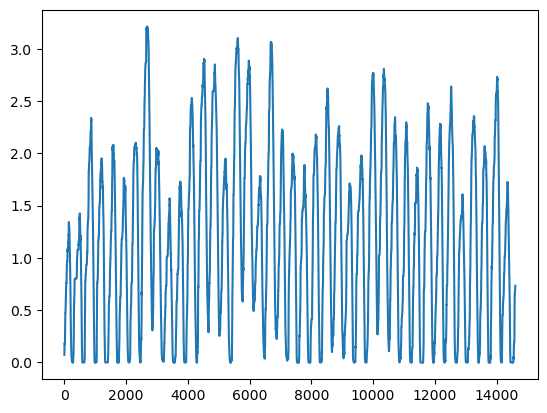

In [18]:
plt.plot(model.snow_depth_list)

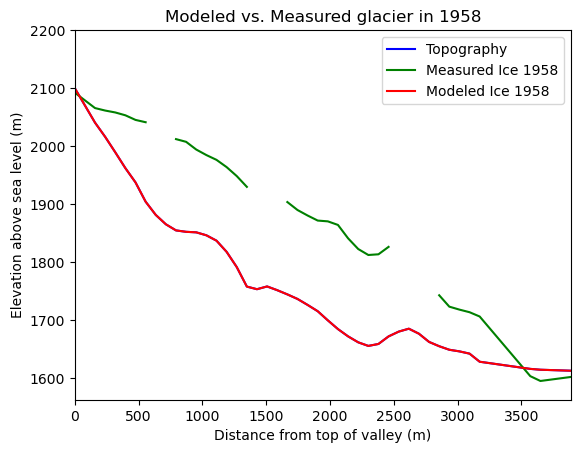

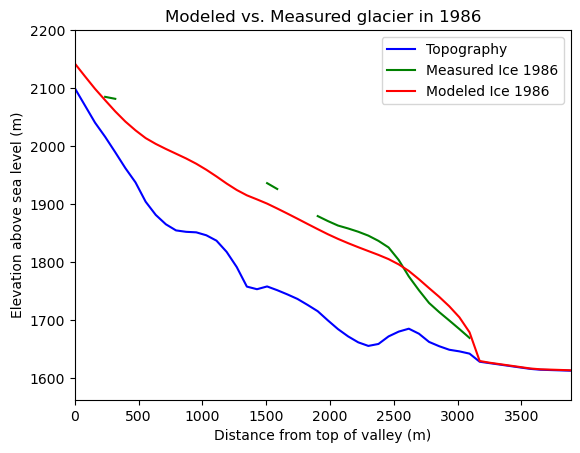

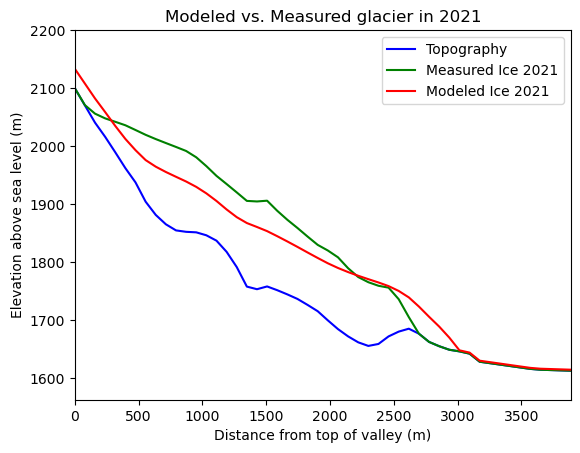

In [19]:
# fig, ax = plt.subplots() #initialize plotting variables
# print("2021 Extent: ",np.nanmax(model.x[model.thickness_2021_verif > 2]))
# print("2021 Max Ice Thickness: ",np.nanmax(model.thickness_2021_verif))
plt.ylim(min(model.topo)-50, max(model.topo) + 100)
plt.xlim(0, float(model.valley_length))
plt.ylabel("Elevation above sea level (m)")
plt.xlabel("Distance from top of valley (m)")
# plt.gca().set_aspect('equal', adjustable='datalim')
plt.title("Modeled vs. Measured glacier in 1958")
plt.plot(model.x, model.topo, color="b", label="Topography")
plt.plot(model.x,model.thickness_1958_verif+model.topo, color="g", label="Measured Ice 1958")
plt.plot(model.x, model.ice_1958+model.topo, color="r", label="Modeled Ice 1958")
plt.legend()
plt.show()
plt.ylim(min(model.topo) - 50, max(model.topo) + 100)
plt.xlim(0, float(model.valley_length))
plt.ylabel("Elevation above sea level (m)")
plt.xlabel("Distance from top of valley (m)")
# plt.gca().set_aspect('equal', adjustable='datalim')
plt.title("Modeled vs. Measured glacier in 1986")
plt.plot(model.x, model.topo, color="b", label="Topography")
plt.plot(model.x,model.thickness_1986_verif+model.topo, color="g", label="Measured Ice 1986")
plt.plot(model.x, model.ice_1986+model.topo, color="r", label="Modeled Ice 1986")
plt.legend()
plt.show()
plt.ylim(min(model.topo) - 50, max(model.topo) + 100)
plt.xlim(0, float(model.valley_length))
plt.ylabel("Elevation above sea level (m)")
plt.xlabel("Distance from top of valley (m)")
# plt.gca().set_aspect('equal', adjustable='datalim')
plt.title("Modeled vs. Measured glacier in 2021")
plt.plot(model.x, model.topo, color="b", label="Topography")
plt.plot(model.x,model.thickness_2021_verif+model.topo, color="g", label="Measured Ice 2021")
plt.plot(model.x, model.ice_2021+model.topo, color="r", label="Modeled Ice 2021")
plt.legend()
plt.show()

In [20]:
# import xarray as xr
# import geopandas as gpd
# import rioxarray

# # Load the NetCDF file
# file_path = '../Data/SouthCascadeData/ALA_G0120_1985.nc'  # Replace with the path to your NetCDF file
# ds = xr.open_dataset(file_path)

# # Set the CRS for the NetCDF dataset
# ds = ds.rio.write_crs("EPSG:3413")

# # Load the shapefile
# shapefile_path = '../Data/SouthCascadeData/large_polygon.shp'  # Replace with the path to your shapefile
# gdf = gpd.read_file(shapefile_path)

# # Ensure the shapefile and NetCDF data have the same CRS (Coordinate Reference System)
# gdf = gdf.to_crs("EPSG:3413")

# # Check if the variable 'v' exists in the dataset
# if 'v' in ds.variables:
#     # Ensure the dataset has spatial dimensions set
#     ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

#     # Clip the NetCDF data to the shapefile polygon
#     clipped = ds.rio.clip(gdf.geometry, gdf.crs)

#     # Calculate the maximum value of the variable 'v' within the clipped region
#     max_v = clipped['v'].max().item()

#     print("Maximum value of 'v' within the shapefile polygon:", max_v)
# else:
#     print("Variable 'v' not found in the dataset.")

In [21]:
#Find average slope of glacier from 2021 DEM
print(np.degrees(np.arctan(np.mean(-(np.diff(model.thickness_2021_verif+model.topo) / model.dx)))))

7.14113159461871


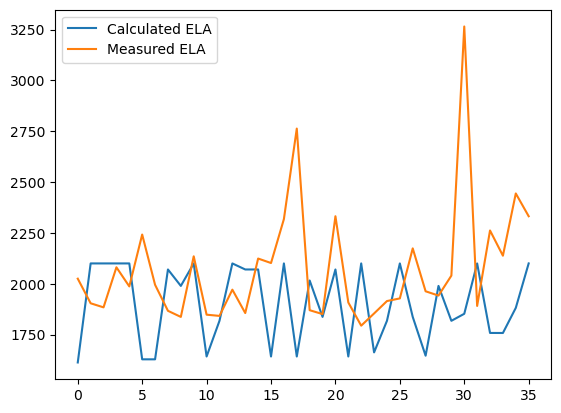

In [22]:
plt.plot(model.ela_list, label="Calculated ELA")
plt.plot(model.ela_verif, label="Measured ELA")
plt.legend()
plt.show()

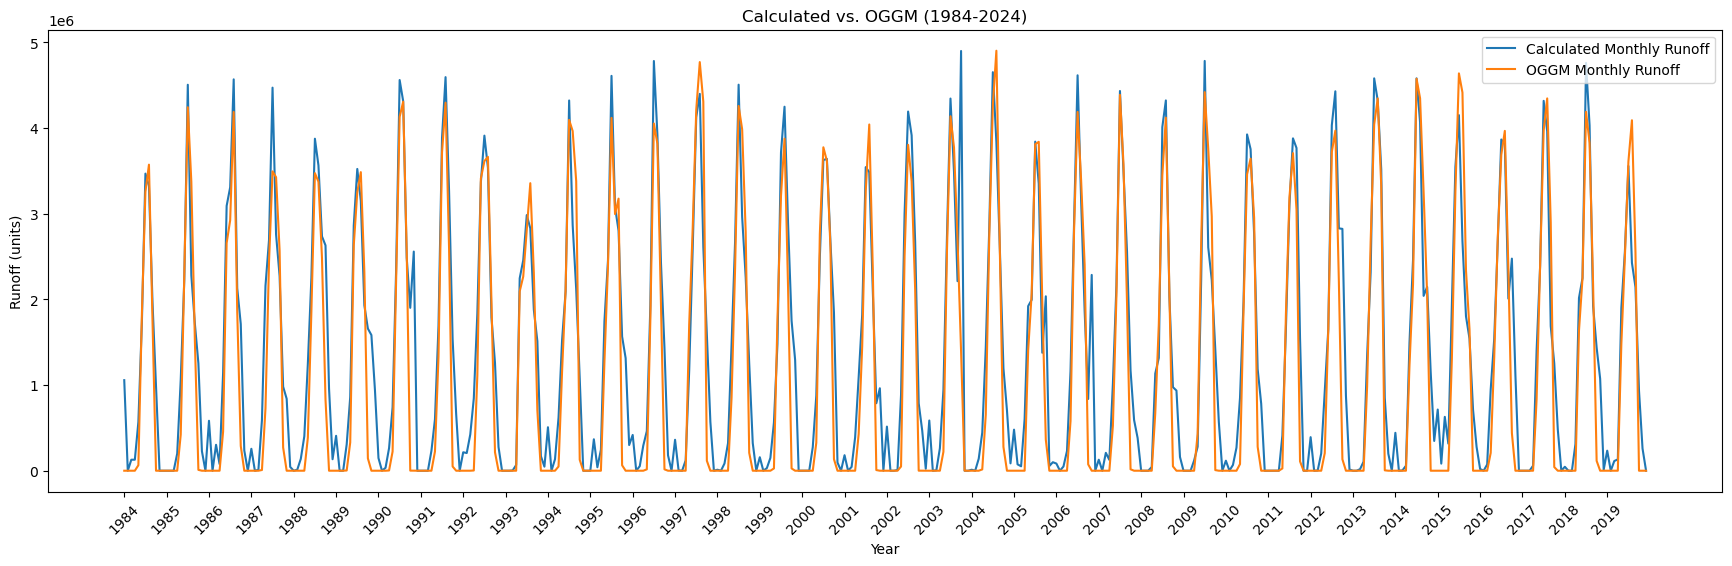

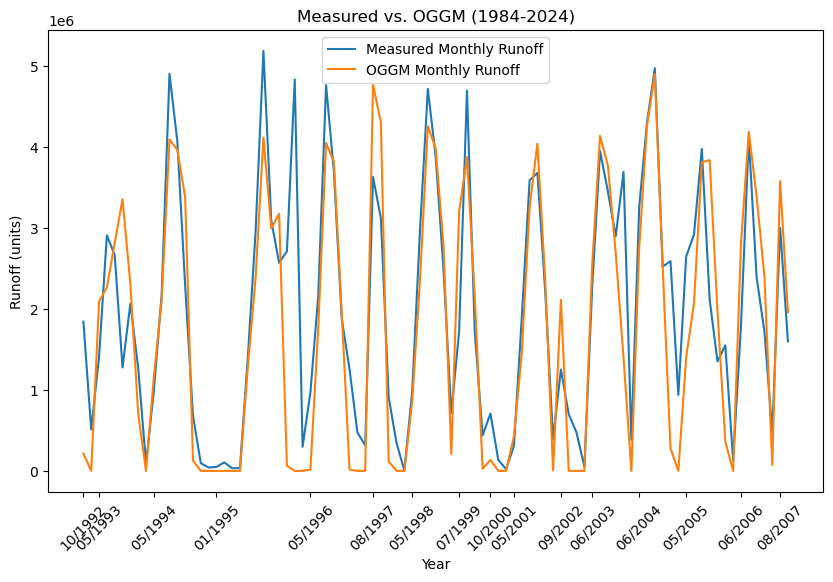

MSE of Calculated vs. OGGM:  0.015613126453221866
MSE of Measured vs. OGGM:  0.032229901955169005


Text(0.5, 1.0, 'MSE of Calculated vs. OGGM Monthly Runoff')

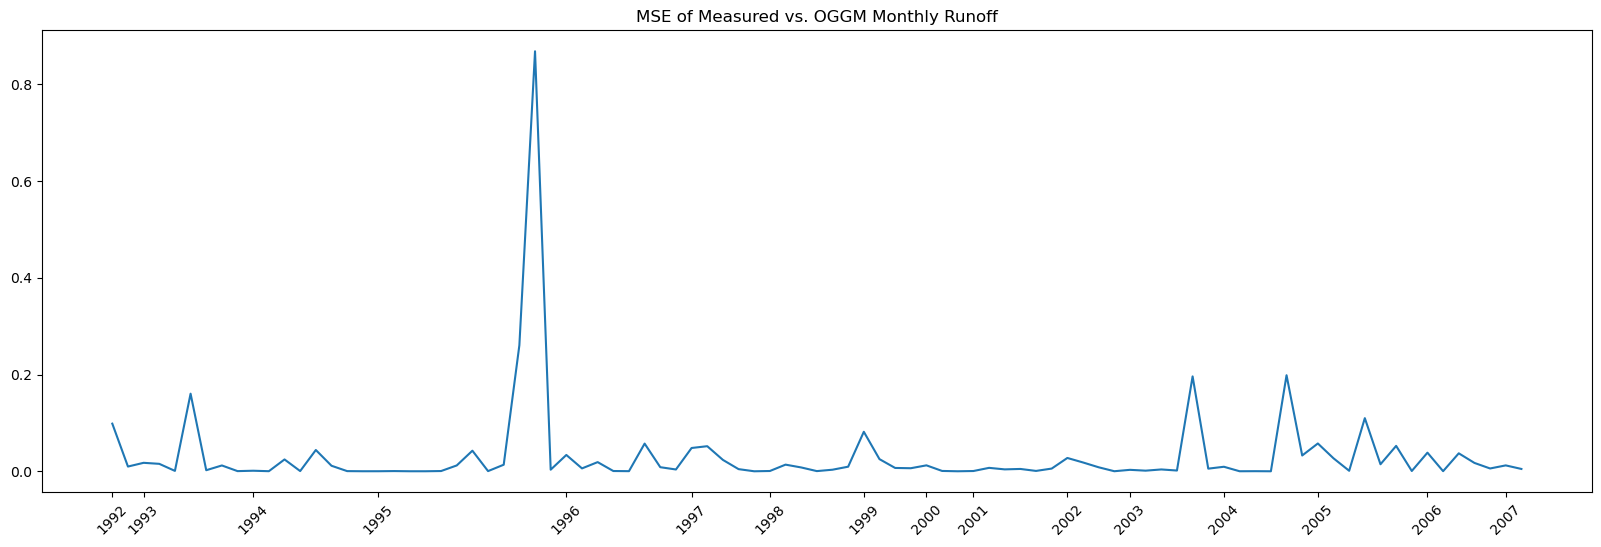

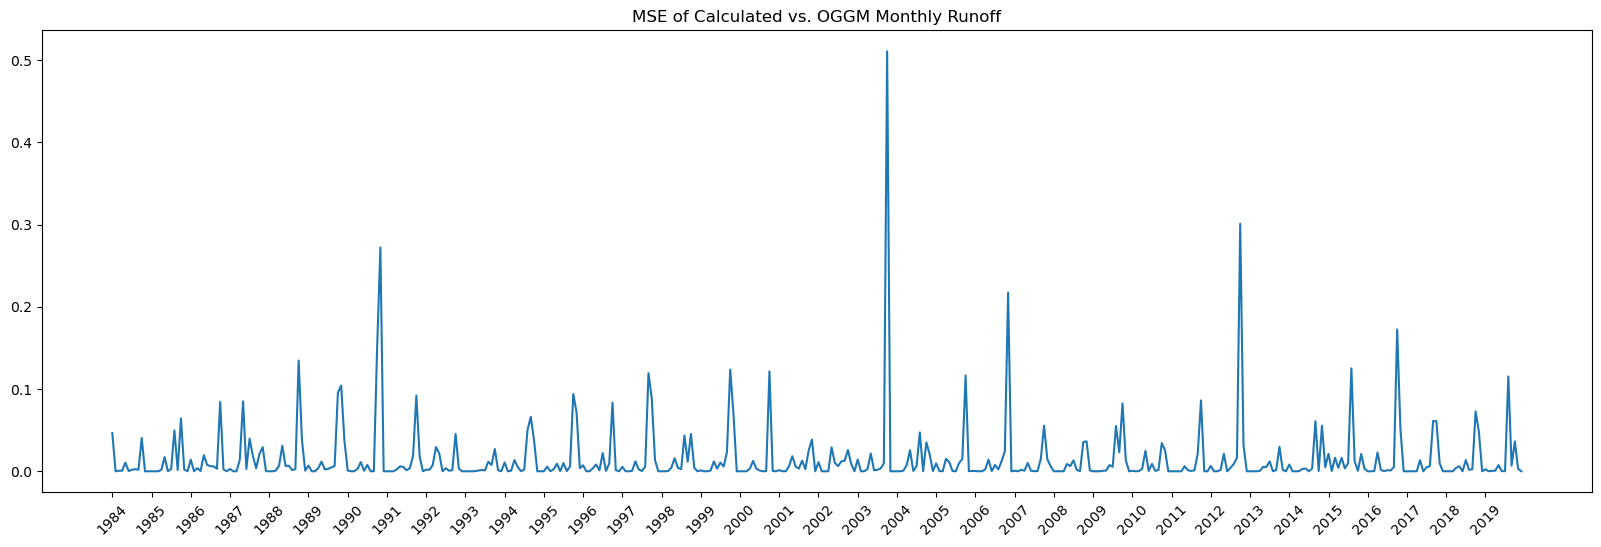

In [23]:
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_all.keys())),'volume_change': model.daily_runoff_all_data})
df['date'] = df['date'].dt.to_period('M')
monthly_volume_change_all=df.groupby('date')['volume_change'].sum().to_numpy()
month_labels_all = df.groupby(df['date'].dt.year)['date'].first().dt.strftime('%m/%Y').to_numpy()
monthly_index_all=df.groupby('date')['volume_change'].sum().index
unique_years_all=sorted(df['date'].dt.year.unique())
# df_oggm = pd.read_csv('Data/oggm_runoff_monthly.csv', index_col=0, parse_dates=True)
# df_oggm.index = df_oggm.index.to_period('M')
# df_oggm_filtered = df_oggm[df_oggm.index.isin(pd.to_datetime(pd.Series(list(model.date_index_all.keys()))).dt.to_period('M').unique())]
# month_labels_oggm = df_oggm.index.strftime('%Y-%m').tolist()
# oggm_runoff_monthly=df_oggm['melt_on_glacier_monthly'].to_numpy()
# oggm_runoff_monthly_filtered=df_oggm_filtered['melt_on_glacier_monthly'].to_numpy()
# years_array = df_oggm.index.year.values  # e.g. array([1984, 1984, 1984, ..., 2024, ...])
df_oggm = pd.read_csv('Data/oggm_runoff_2.csv', index_col=0, parse_dates=True)
df_oggm.index = df_oggm.index.to_period('M')
month_labels_oggm = df_oggm.index.strftime('%Y-%m').tolist()
df_oggm_filtered = df_oggm[df_oggm.index.isin(pd.to_datetime(pd.Series(list(model.date_index_all.keys()))).dt.to_period('M').unique())]
years_array = df_oggm.index.year.values
oggm_runoff_all=df_oggm['basin_runoff'].to_numpy()/1000
oggm_runoff_all_filtered=df_oggm_filtered['basin_runoff'].to_numpy()/1000
# Identify the unique years and choose the first occurrence in the index for each year
unique_years = np.unique(years_array)
tick_positions = []
tick_labels = []
for year in unique_years:
    # Find the first index where the year occurs
    pos = np.where(years_array == year)[0][0]
    tick_positions.append(pos)
    tick_labels.append(str(year))
fig, ax = plt.subplots(figsize=(max(10, len(tick_labels) * 0.6), 6))
ax.plot(model.monthly_runoff_all[:-49], label='Calculated Monthly Runoff')
# ax.plot(model.measured_runoff_all, label='Measured Monthly Runoff')
ax.plot(oggm_runoff_all, label='OGGM Monthly Runoff')
ax.set_xlabel('Year')
ax.set_ylabel('Runoff (units)')
ax.set_title('Calculated vs. OGGM (1984-2024)')
# ax.set_xticks(ticks=np.arange(len(month_labels_oggm)), labels=month_labels_oggm, rotation=45)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.legend()
plt.show()
years_array = df_oggm_filtered.index.year.values  # e.g. array([1984, 1984, 1984, ..., 2024, ...])
# Identify the unique years and choose the first occurrence in the index for each year
unique_years = np.unique(years_array)
tick_positions = []
tick_labels = []
for year in unique_years:
    # Find the first index where the year occurs
    pos = np.where(years_array == year)[0][0]
    tick_positions.append(pos)
    tick_labels.append(str(year))
year_positions_all = []
for y in unique_years_all:
    idxs = np.where(monthly_index_all.year == y)[0]
    if len(idxs) > 0: year_positions_all.append(idxs[0])
fig, ax = plt.subplots(figsize=(max(10, len(tick_labels) * 0.6), 6))
ax.plot(model.measured_runoff_all, label='Measured Monthly Runoff')
# ax.plot(model.measured_runoff_all, label='Measured Monthly Runoff')
ax.plot(oggm_runoff_all_filtered, label='OGGM Monthly Runoff')
ax.set_xlabel('Year')
ax.set_ylabel('Runoff (units)')
ax.set_title('Measured vs. OGGM (1984-2024)')
# ax.set_xticks(ticks=np.arange(len(month_labels_oggm)), labels=month_labels_oggm, rotation=45)
ax.set_xticks(tick_positions)
ax.set_xticks(ticks=year_positions_all, labels=month_labels_all, rotation=45)
ax.legend()
plt.show()
calculated_monthly_runoff_1984_2019=model.monthly_runoff_all[:-49]
all_min=min(np.nanmin(calculated_monthly_runoff_1984_2019),np.nanmin(oggm_runoff_all))
all_max=max(np.nanmax(calculated_monthly_runoff_1984_2019),np.nanmax(oggm_runoff_all))
monthly_volume_change_all_normalized = (calculated_monthly_runoff_1984_2019-all_min)/(all_max-all_min)
oggm_runoff_monthly_normalized= (oggm_runoff_all-all_min)/(all_max-all_min)
print("MSE of Calculated vs. OGGM: ", np.mean((monthly_volume_change_all_normalized-oggm_runoff_monthly_normalized)**2))
all_min=min(np.nanmin(model.measured_runoff_all),np.nanmin(oggm_runoff_all_filtered))
all_max=max(np.nanmax(model.measured_runoff_all),np.nanmax(oggm_runoff_all_filtered))
measured_runoff_all_normalized= (model.measured_runoff_all-all_min)/(all_max-all_min)
oggm_runoff_monthly_filtered_normalized= (oggm_runoff_all_filtered-all_min)/(all_max-all_min)
print("MSE of Measured vs. OGGM: ", np.mean((measured_runoff_all_normalized-oggm_runoff_monthly_filtered_normalized)**2))
fig,ax  = plt.subplots(figsize=(20, 6))
ax.plot((measured_runoff_all_normalized-oggm_runoff_monthly_filtered_normalized)**2)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_title("MSE of Measured vs. OGGM Monthly Runoff")
years_array = df_oggm.index.year.values
unique_years = np.unique(years_array)
tick_positions = []
tick_labels = []
for year in unique_years:
    # Find the first index where the year occurs
    pos = np.where(years_array == year)[0][0]
    tick_positions.append(pos)
    tick_labels.append(str(year))
fig,ax  = plt.subplots(figsize=(20, 6))
ax.plot((monthly_volume_change_all_normalized-oggm_runoff_monthly_normalized)**2)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_title("MSE of Calculated vs. OGGM Monthly Runoff")


2015 extent is 2114

MSE Winter:  0.03623558955989751


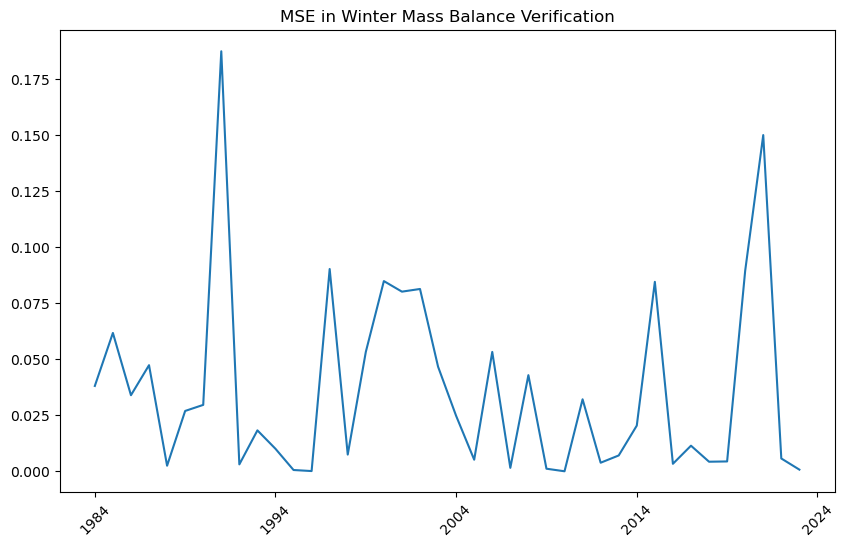

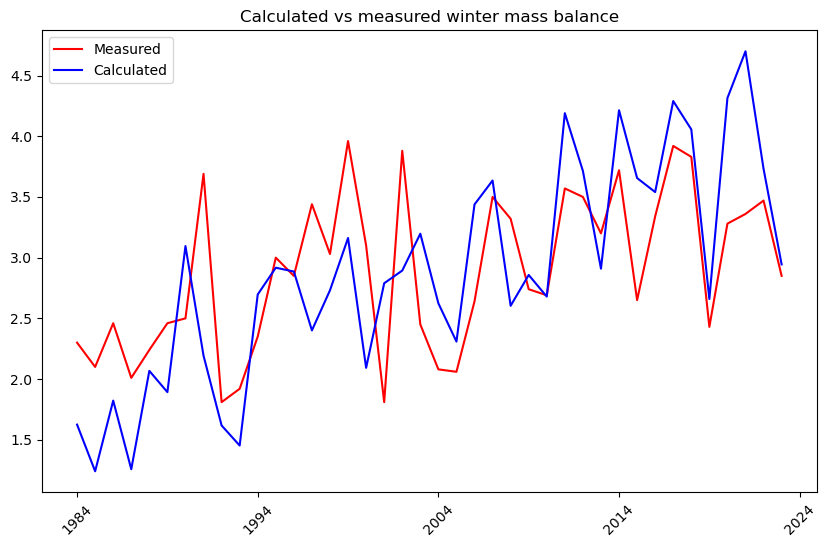

MSE Summer:  0.01726224888486171


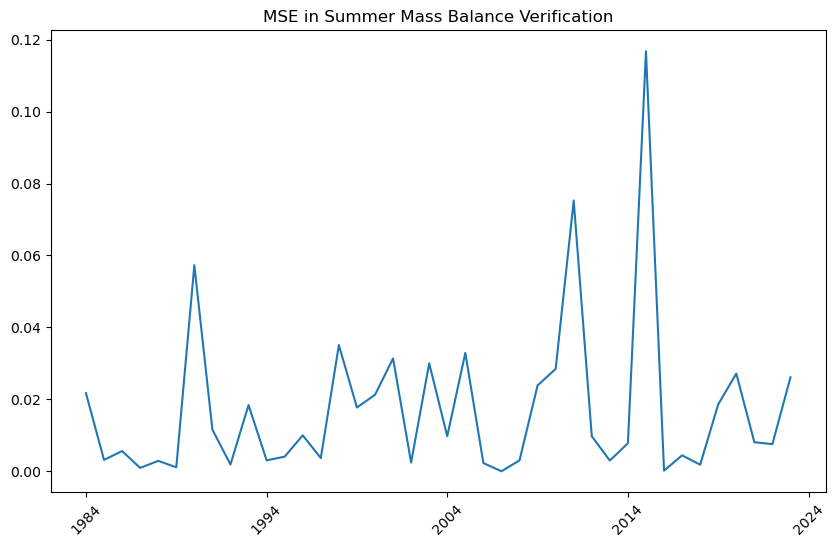

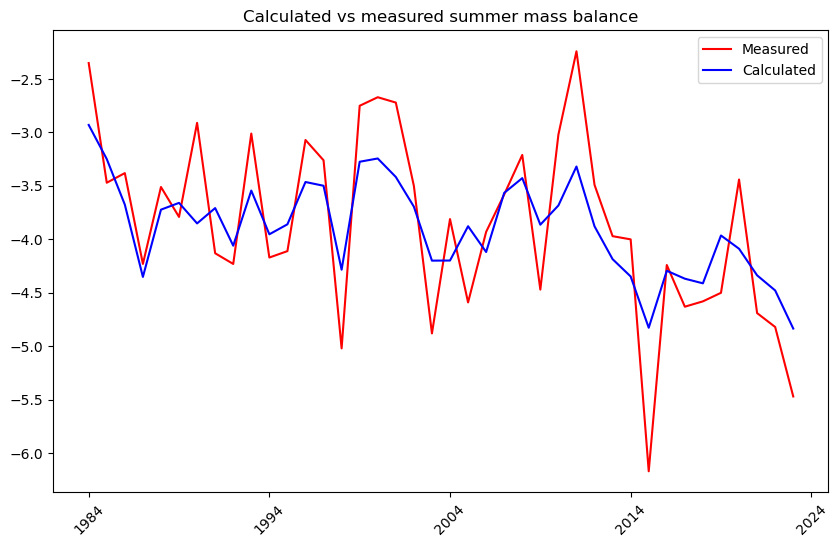

MSE Training:  0.00966410198600218
MSE Verif:  0.015438428722822688
MSE All:  0.01405428221290257
RMSE Training:  0.0983061645371346
RMSE Verif:  0.124251473724953
RMSE All:  0.11855075796005089


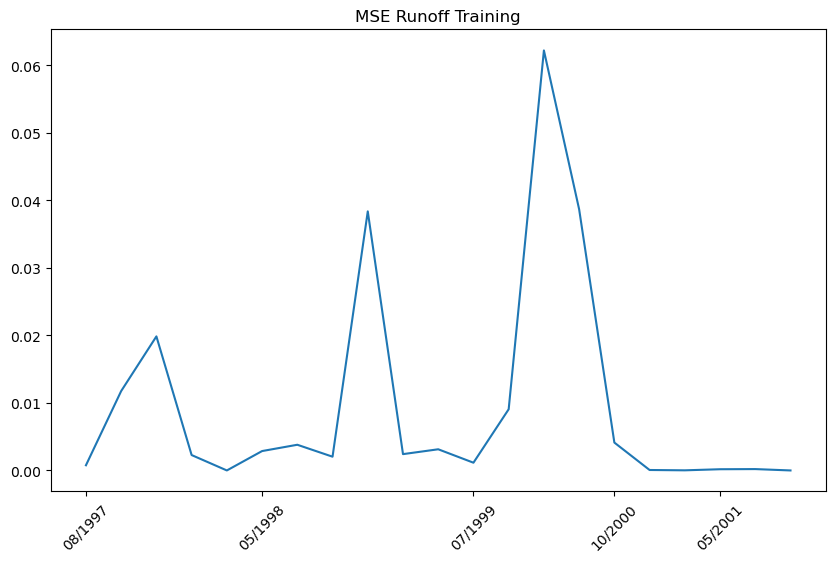

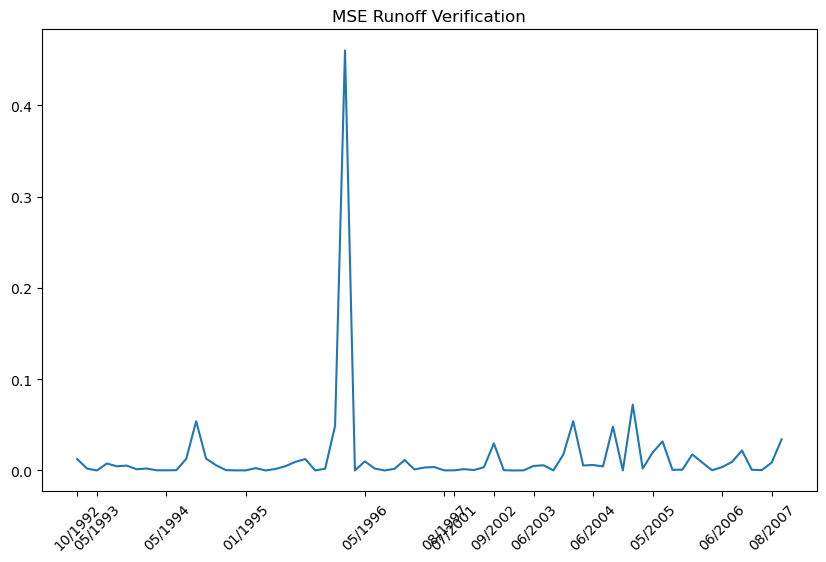

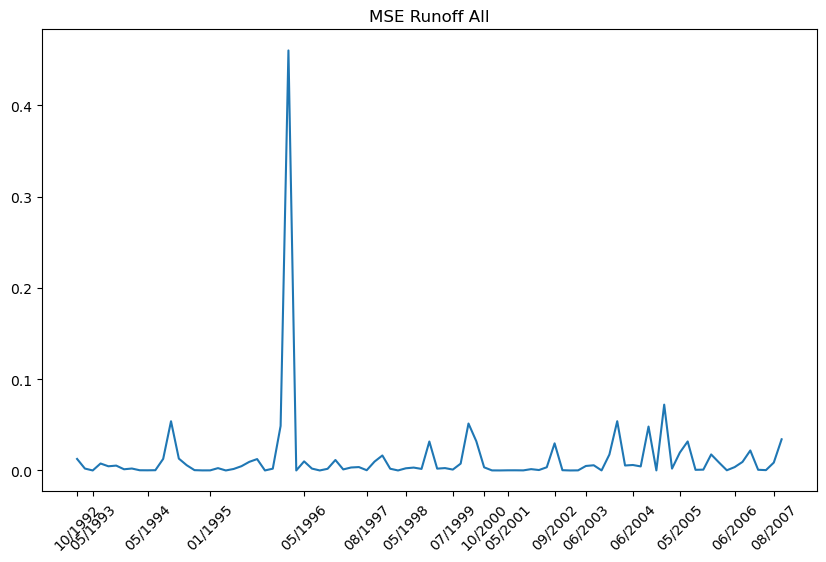

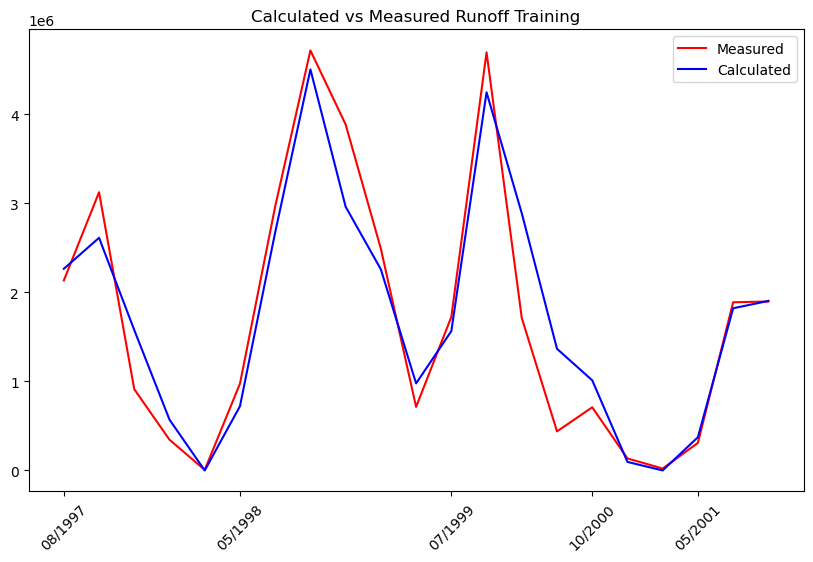

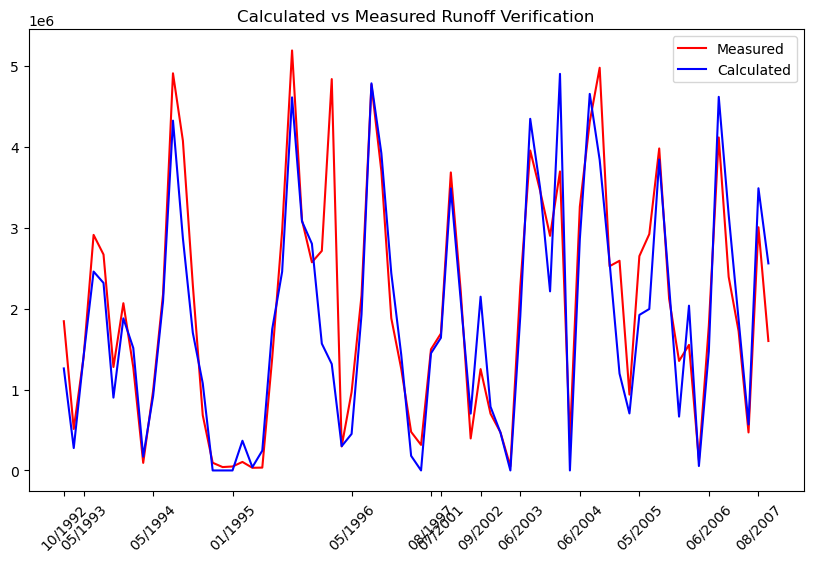

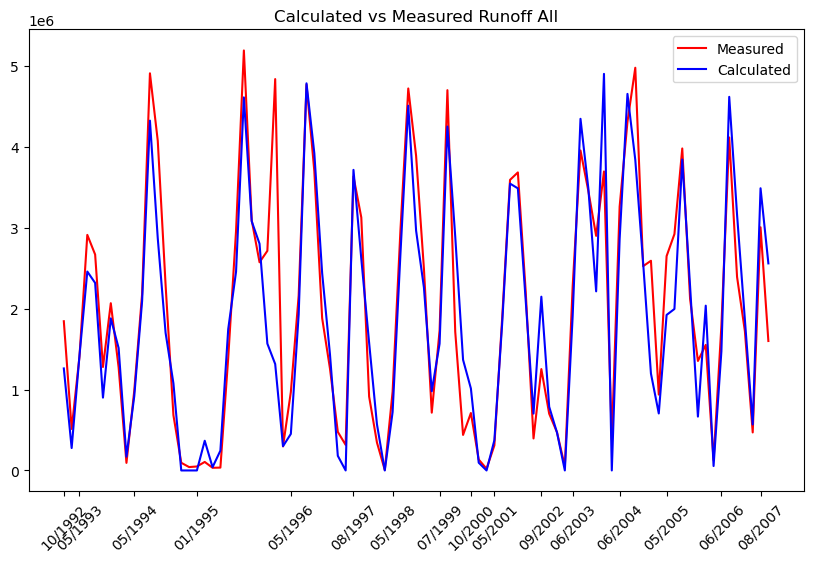

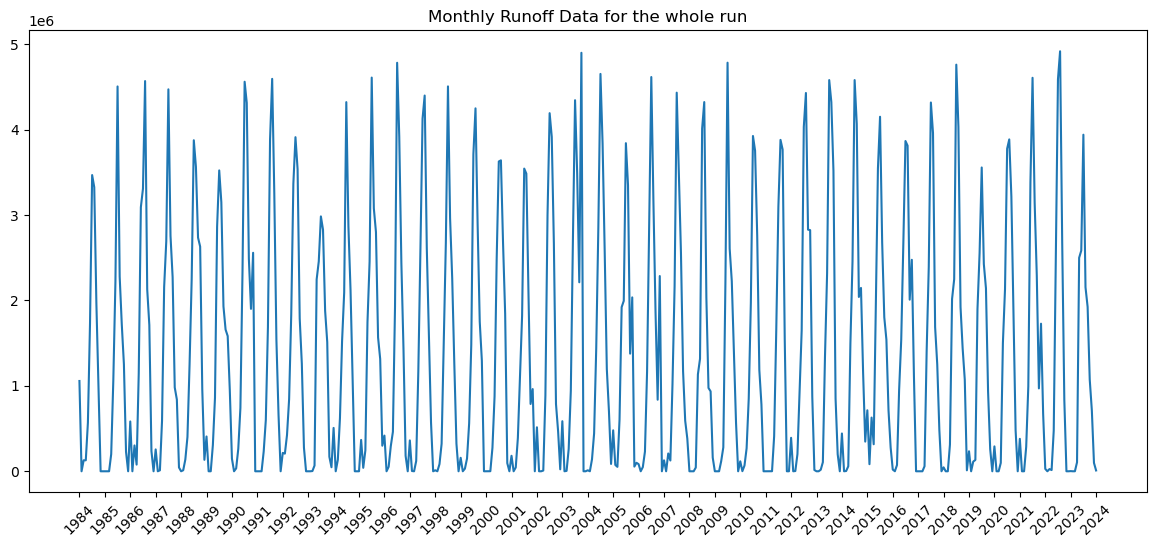

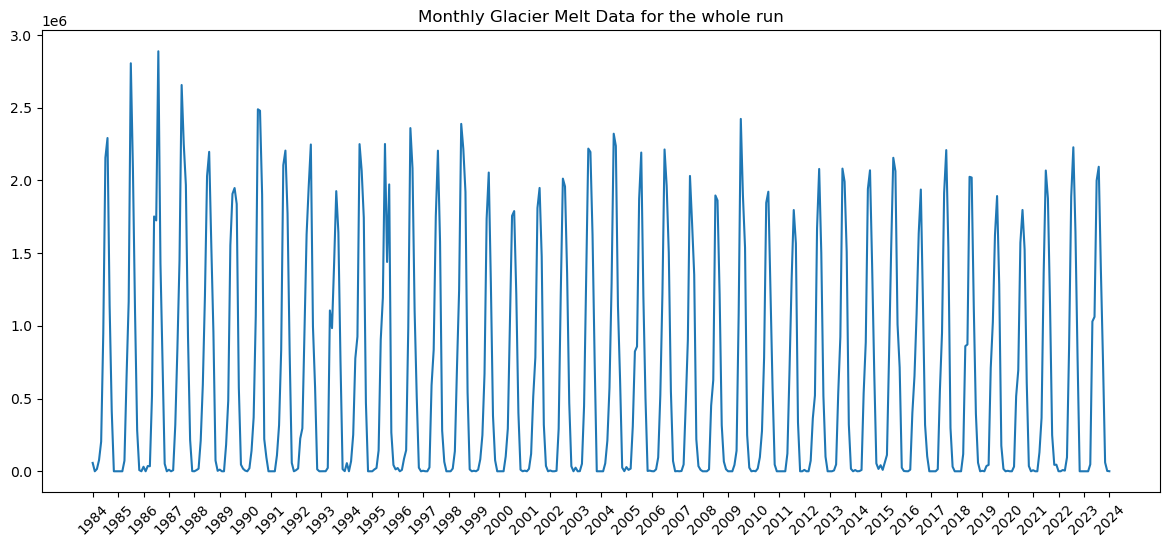

Average percentage of runoff that is glacier melt:  37.94711079216764


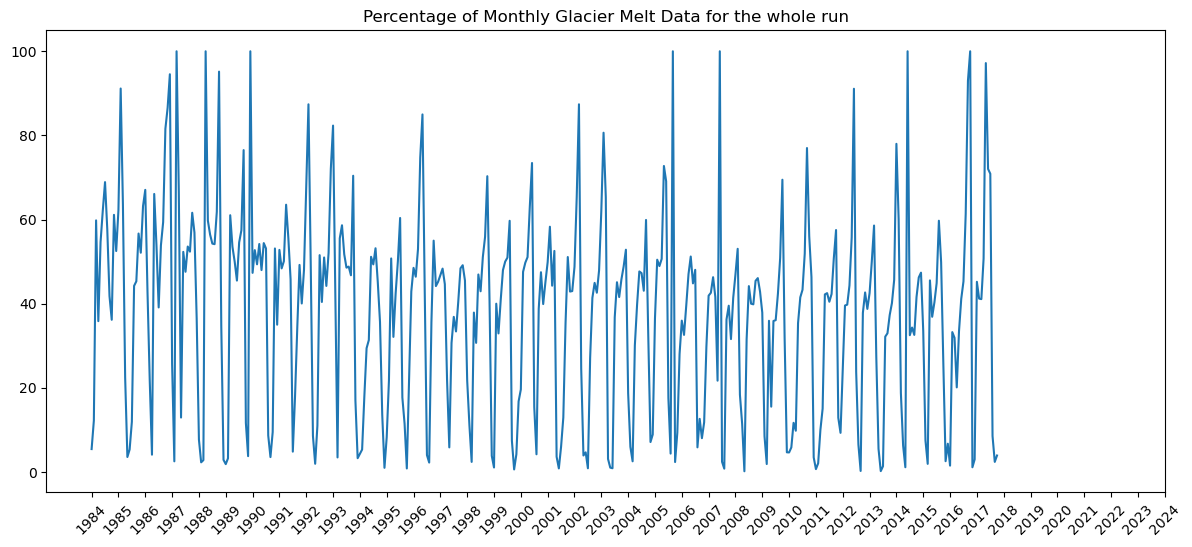

Average percentage of runoff that is not glacier melt:  62.05288920783236


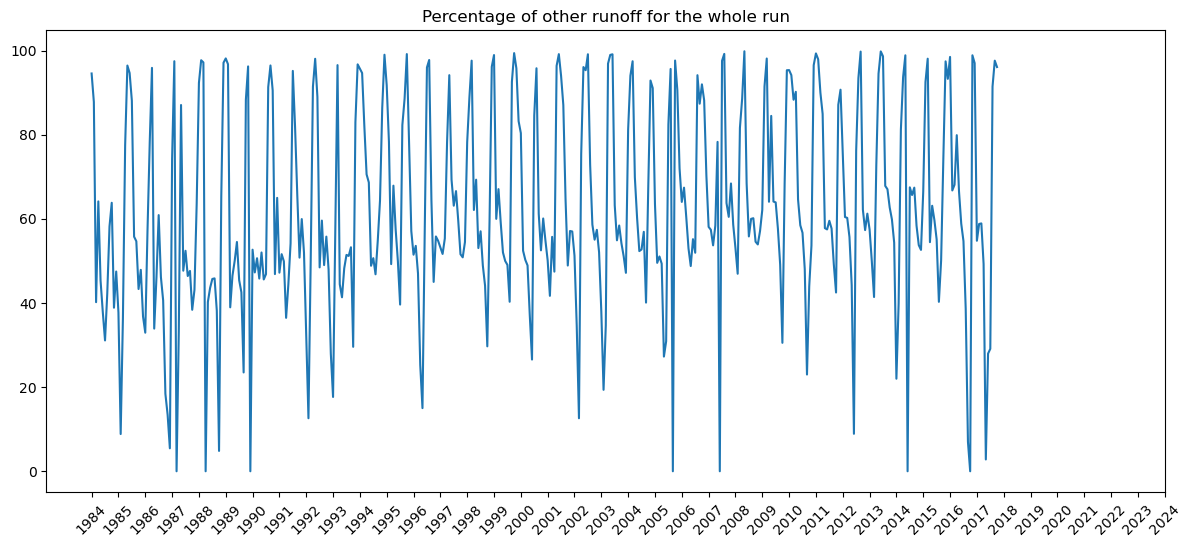

In [24]:
winter_min=min(np.nanmin(model.calculated_winter_mb),np.nanmin(model.winter_mb))
winter_max=max(np.nanmax(model.calculated_winter_mb),np.nanmax(model.winter_mb))
calc_winter_mb_norm=(model.calculated_winter_mb-winter_min)/(winter_max-winter_min)
meas_winter_mb_norm= (np.array(model.winter_mb)-winter_min)/(winter_max-winter_min)
mb_years=np.arange(1984,2025,10)
mb_year_positions=np.arange(0,41,10)
print("MSE Winter: ", np.mean((calc_winter_mb_norm-meas_winter_mb_norm)**2))
plt.figure(figsize=(max(10, len(mb_years) * 0.4), 6))
plt.plot((calc_winter_mb_norm-meas_winter_mb_norm)**2)
plt.title("MSE in Winter Mass Balance Verification")
plt.xticks(ticks=mb_year_positions, labels=mb_years, rotation=45)
plt.show()
plt.figure(figsize=(max(10, len(mb_years) * 0.4), 6))
plt.plot(model.winter_mb, c='r', label="Measured")
plt.plot(model.calculated_winter_mb, c='b', label="Calculated")
plt.xticks(ticks=mb_year_positions, labels=mb_years, rotation=45)
plt.legend()
plt.title("Calculated vs measured winter mass balance")
plt.show()
summer_min=min(np.nanmin(model.calculated_summer_mb),np.nanmin(model.summer_mb))
summer_max=max(np.nanmax(model.calculated_summer_mb),np.nanmax(model.summer_mb))
calc_summer_mb_norm=(model.calculated_summer_mb-summer_min)/(summer_max-summer_min)
meas_summer_mb_norm= (np.array(model.summer_mb)-summer_min)/(summer_max-summer_min)
print("MSE Summer: ", np.mean((calc_summer_mb_norm-meas_summer_mb_norm)**2))
plt.figure(figsize=(max(10, len(mb_years) * 0.4), 6))
plt.plot((calc_summer_mb_norm-meas_summer_mb_norm)**2)
plt.title("MSE in Summer Mass Balance Verification")
plt.xticks(ticks=mb_year_positions, labels=mb_years, rotation=45)
plt.show()
plt.figure(figsize=(max(10, len(mb_years) * 0.4), 6))
plt.plot(model.summer_mb, c='r', label="Measured")
plt.plot(model.calculated_summer_mb, c='b', label="Calculated")
plt.xticks(ticks=mb_year_positions, labels=mb_years, rotation=45)
plt.legend()
plt.title("Calculated vs measured summer mass balance")
plt.show()
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_verif.keys())),'volume_change': model.daily_runoff_verif})
df['date'] = df['date'].dt.to_period('M')
verif_min=min(np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmin(model.measured_runoff_verif))
verif_max=max(np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmax(model.measured_runoff_verif))
monthly_volume_change_verif=df.groupby('date')['volume_change'].sum().to_numpy()
monthly_volume_change_verif_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-verif_min)/(verif_max-verif_min)
measured_runoff_verif_normalized= (model.measured_runoff_verif-verif_min)/(verif_max-verif_min)
month_labels_verif = df.groupby(df['date'].dt.year)['date'].first().dt.strftime('%m/%Y').to_numpy()
monthly_index_verif=df.groupby('date')['volume_change'].sum().index
unique_years_verif=sorted(df['date'].dt.year.unique())
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_all.keys())),'volume_change': model.daily_runoff_all_data})
df['date'] = df['date'].dt.to_period('M')
all_min=min(np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmin(model.measured_runoff_all))
all_max=max(np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmax(model.measured_runoff_all))
monthly_volume_change_all=df.groupby('date')['volume_change'].sum().to_numpy()
monthly_volume_change_all_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-all_min)/(all_max-all_min)
measured_runoff_all_normalized= (model.measured_runoff_all-all_min)/(all_max-all_min)
month_labels_all = df.groupby(df['date'].dt.year)['date'].first().dt.strftime('%m/%Y').to_numpy()
monthly_index_all=df.groupby('date')['volume_change'].sum().index
unique_years_all=sorted(df['date'].dt.year.unique())
df = pd.DataFrame({'date': pd.to_datetime(list(model.date_index_training.keys())),'volume_change': model.daily_runoff_training})
df['date'] = df['date'].dt.to_period('M')
train_min=min(np.nanmin(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmin(model.measured_runoff_training))
train_max=max(np.nanmax(df.groupby('date')['volume_change'].sum().to_numpy()),np.nanmax(model.measured_runoff_training))
monthly_volume_change_train=df.groupby('date')['volume_change'].sum().to_numpy()
monthly_volume_change_train_normalized = (df.groupby('date')['volume_change'].sum().to_numpy()-train_min)/(train_max-train_min)
measured_runoff_train_normalized= (model.measured_runoff_training-train_min)/(train_max-train_min)
month_labels_train = df.groupby(df['date'].dt.year)['date'].first().dt.strftime('%m/%Y').to_numpy()
monthly_index_train=df.groupby('date')['volume_change'].sum().index
unique_years_train=sorted(df['date'].dt.year.unique())
print("MSE Training: ", np.mean((monthly_volume_change_train_normalized-measured_runoff_train_normalized)**2))
print("MSE Verif: ", np.mean((monthly_volume_change_verif_normalized-measured_runoff_verif_normalized)**2))
print("MSE All: ", np.mean((monthly_volume_change_all_normalized-measured_runoff_all_normalized)**2))
print("RMSE Training: ", np.sqrt(np.mean((monthly_volume_change_train_normalized-measured_runoff_train_normalized)**2)))
print("RMSE Verif: ", np.sqrt(np.mean((monthly_volume_change_verif_normalized-measured_runoff_verif_normalized)**2)))
print("RMSE All: ", np.sqrt(np.mean((monthly_volume_change_all_normalized-measured_runoff_all_normalized)**2)))
year_positions_train = []
for y in unique_years_train:
    idxs = np.where(monthly_index_train.year == y)[0]
    if len(idxs) > 0: year_positions_train.append(idxs[0])
plt.figure(figsize=(max(10, len(month_labels_train) * 0.4), 6))
plt.plot((monthly_volume_change_train_normalized-measured_runoff_train_normalized)**2)
plt.xticks(ticks=year_positions_train, labels=month_labels_train, rotation=45)
plt.title("MSE Runoff Training")
plt.show()
year_positions_verif = []
for y in unique_years_verif:
    idxs = np.where(monthly_index_verif.year == y)[0]
    if len(idxs) > 0: year_positions_verif.append(idxs[0])
plt.figure(figsize=(max(10, len(month_labels_verif) * 0.4), 6))
plt.plot((monthly_volume_change_verif_normalized-measured_runoff_verif_normalized)**2)
plt.xticks(ticks=year_positions_verif, labels=month_labels_verif, rotation=45)
plt.title("MSE Runoff Verification")
plt.show()
year_positions_all = []
for y in unique_years_all:
    idxs = np.where(monthly_index_all.year == y)[0]
    if len(idxs) > 0: year_positions_all.append(idxs[0])
plt.figure(figsize=(max(10, len(month_labels_all) * 0.4), 6))
plt.plot((monthly_volume_change_all_normalized-measured_runoff_all_normalized)**2)
plt.xticks(ticks=year_positions_all, labels=month_labels_all, rotation=45)
plt.title("MSE Runoff All")
plt.show()
plt.figure(figsize=(max(10, len(month_labels_train) * 0.4), 6))
plt.plot(model.measured_runoff_training, c='r', label="Measured")
plt.plot(monthly_volume_change_train, c='b', label="Calculated")
plt.title("Calculated vs Measured Runoff Training")
plt.xticks(ticks=year_positions_train, labels=month_labels_train, rotation=45)
plt.legend()
plt.show()
plt.figure(figsize=(max(10, len(month_labels_verif) * 0.4), 6))
plt.plot(model.measured_runoff_verif, c='r', label="Measured")
plt.plot(monthly_volume_change_verif, c='b', label="Calculated")
plt.xticks(ticks=year_positions_verif, labels=month_labels_verif, rotation=45)
plt.title("Calculated vs Measured Runoff Verification")
plt.legend()
plt.show()
plt.figure(figsize=(max(10, len(month_labels_all) * 0.4), 6))
plt.plot(model.measured_runoff_all, c='r', label="Measured")
plt.plot(monthly_volume_change_all, c='b', label="Calculated")
plt.xticks(ticks=year_positions_all, labels=month_labels_all, rotation=45)
plt.title("Calculated vs Measured Runoff All")
plt.legend()
plt.show()
monthly_runoff_all_year_labels = [str(1984 + i // 12) if i % 12 == 0 else '' for i in range(len(model.monthly_runoff_all))] 
plt.figure(figsize=(max(10, len(monthly_runoff_all_year_labels) * 0.03), 6))
plt.plot(model.monthly_runoff_all)
plt.title("Monthly Runoff Data for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_runoff_all_year_labels) if label], labels=[label for label in monthly_runoff_all_year_labels if label], rotation=45)
plt.show()
monthly_glacier_melt_year_labels = [str(1984 + i // 12) if i % 12 == 0 else '' for i in range(len(model.monthly_glacier_melt))] 
plt.figure(figsize=(max(10, len(monthly_glacier_melt_year_labels) * 0.03), 6))
plt.plot(model.monthly_glacier_melt)
plt.title("Monthly Glacier Melt Data for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_glacier_melt_year_labels) if label], labels=[label for label in monthly_glacier_melt_year_labels if label], rotation=45)
plt.show()
monthly_percent_glacier_melt_labels = [str(1984 + i // 12) if i % 12 == 0 else '' for i in range(len(model.monthly_glacier_melt))] 
plt.figure(figsize=(max(10, len(monthly_percent_glacier_melt_labels) * 0.03), 6))
percentage_glacier_melt=model.monthly_glacier_melt[model.monthly_runoff_all>0]/model.monthly_runoff_all[model.monthly_runoff_all>0]*100
# percentage_glacier_melt[model.monthly_runoff_all==0]=0
print("Average percentage of runoff that is glacier melt: ", np.mean(percentage_glacier_melt))
plt.plot(percentage_glacier_melt)
plt.title("Percentage of Monthly Glacier Melt Data for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_percent_glacier_melt_labels) if label], labels=[label for label in monthly_percent_glacier_melt_labels if label], rotation=45)
plt.show()
percentage_not_glacier_melt=(model.monthly_runoff_all[model.monthly_runoff_all>0]-model.monthly_glacier_melt[model.monthly_runoff_all>0])/model.monthly_runoff_all[model.monthly_runoff_all>0]*100
# percentage_not_glacier_melt[model.monthly_runoff_all==0]=0
print("Average percentage of runoff that is not glacier melt: ", np.mean(percentage_not_glacier_melt))
plt.figure(figsize=(max(10, len(monthly_percent_glacier_melt_labels) * 0.03), 6))
plt.plot(percentage_not_glacier_melt)
plt.title("Percentage of other runoff for the whole run")
plt.xticks(ticks=[i for i, label in enumerate(monthly_percent_glacier_melt_labels) if label], labels=[label for label in monthly_percent_glacier_melt_labels if label], rotation=45)
plt.show()

Compute Lapse Rate

In [25]:
# input_file_path = "Data/Input_SouthCascade_Daily_Weather.csv"
# southcascade_file_path = "C:/Users/bookn/Downloads/Senior-Thesis/Data/SouthCascadeData/benchmarkGlacier_weather/southCascade/LVL2/southcascade1830_daily_LVL2.csv"

# # Load the CSV files with date parsing
# df_input = pd.read_csv(input_file_path, parse_dates=['Date'])
# df_southcascade = pd.read_csv(southcascade_file_path, parse_dates=['Date'])

# # Merge data on the date column
# df_merged = pd.merge(df_input, df_southcascade, on='Date', how='inner')

# # Compute lapse rate (temperature difference per unit elevation)
# df_merged['lapse_rate'] = (df_merged['site_temp_WMO'] - df_merged['Temperature']) / (1830 - 272)

# # Compute monthly average lapse rate
# df_merged['month'] = df_merged['Date'].dt.to_period("M")
# monthly_avg_lapse_rate = df_merged.groupby('month')['lapse_rate'].mean().reset_index()
# monthly_avg_lapse_rate = monthly_avg_lapse_rate.dropna()
# monthly_avg_lapse_rate.to_csv("monthly_avg_lapse_rate.csv", index=False)
# monthly_avg_lapse_rate["month_number"] = monthly_avg_lapse_rate["month"].dt.month
# monthly_avg_lapse_rate["year"] = monthly_avg_lapse_rate["month"].dt.year
# average_lapse_rate_by_month = monthly_avg_lapse_rate.groupby("month_number")["lapse_rate"].mean().to_numpy()
# average_lapse_rate_by_year= monthly_avg_lapse_rate.groupby("year")["lapse_rate"].mean().to_numpy()
# print(average_lapse_rate_by_year)
# print(average_lapse_rate_by_month)
# print(np.mean(monthly_avg_lapse_rate['lapse_rate'].to_numpy()))
# print(monthly_avg_lapse_rate)